In [9]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
import numpy as np

import sys
import os

sys.path.append(os.environ['REPO_DIR'] + '/utilities')
from utilities2015 import *

import matplotlib.pyplot as plt
%matplotlib inline

In [11]:
volume_dir = '/oasis/projects/nsf/csd395/yuncong/CSHL_volumes/'

In [12]:
volume1 = np.load(os.path.join(volume_dir, 'volume_MD589_labelmap.npz'))['arr_0']
nx1, ny1, nz1 = volume1.shape
print nx1, ny1, nz1

644 1489 945


In [13]:
test_f, test_l = section_range_lookup['MD594']
print nz1*(157.-143)/(316-143)
print nz1*(166.-143)/(316-143)

76.4739884393
125.63583815


In [14]:
volume2_allLabels = []

for l in range(1, 10):
    volume2 = np.load(os.path.join(volume_dir, 'volume_MD594_scoreMap_%(label)d.npz'%{'label': l}))['arr_0']
    
    volume2[volume2 < 1e-4] = 0
    
    nx2, ny2, nz2 = volume2.shape
    print nx2, ny2, nz2
    
    volume2_allLabels.append(volume2)

750 1380 54
750 1380 54
750 1380 54
750 1380 54
750 1380 54
750 1380 54
750 1380 54
750 1380 54
750 1380 54


In [15]:
labels = ['BackG', '5N', '7n', '7N', '12N', 'Gr', 'LVe', 'Pn', 'SuVe', 'VLL']
label_dict = dict([(l,i) for i, l in enumerate(labels)])

In [ ]:
downsample_factor = 8

section_thickness = 20 # in um
xy_pixel_distance_lossless = 0.46
xy_pixel_distance_tb = xy_pixel_distance_lossless * 32 # in um, thumbnail
# factor = section_thickness/xy_pixel_distance_lossless

xy_pixel_distance_downsampled = xy_pixel_distance_lossless * downsample_factor
z_xy_ratio_downsampled = section_thickness / xy_pixel_distance_downsampled

stack = 'MD594'

n_sec = {'MD589': 445, 'MD594': 432}
    
# build annotation volume
section_bs_begin, section_bs_end = section_range_lookup[stack]
print section_bs_begin, section_bs_end

map_z_to_section = {}
for s in range(157, 167):
    for z in range(int(z_xy_ratio_downsampled*s) - 853, int(z_xy_ratio_downsampled*(s+1)) - 853+1):
        map_z_to_section[z] = s

In [27]:
z_level = 40
label = '7N'

viz1 = cropped_imgs[map_z_to_section[z_level]]
# viz2 = colors[test_volume_atlas_projected[...,z]]
viz3 = plt.cm.hot(volume2_allLabels[label_dict[label]-1][...,z_level])[...,:3]
# viz = img_as_ubyte(alpha_blending(viz3, alpha_blending(viz2, viz1[...,:3], .2, 1.)[...,:3], .1, 1))
viz = img_as_ubyte(alpha_blending(viz3, viz1[...,:3], .5, 1))

display(viz)

# figure, axes = plt.subplots(2,1, sharex=True, sharey=True, figsize=(20,20))
# axes[0].matshow(volume1[...,0]);
# axes[1].matshow(volume2_allLabels[label_dict['5N']-1][...,10]);

/oasis/projects/nsf/csd395/yuncong/Brain/cross-brain/tmp.jpg

In [9]:
from joblib import Parallel, delayed

In [58]:
def parallel_where(l):
    return np.where(volume1==l)

import time
t = time.time()

atlas_nzs = Parallel(n_jobs=16)(delayed(parallel_where)(l) for l in range(1,10))

print time.time() - t, 'seconds'

atlas_xmin, atlas_ymin, atlas_zmin = np.min([np.min(atlas_nzs[l-1], axis=1) for l in range(1,10)], axis=0)
atlas_xmax, atlas_ymax, atlas_zmax = np.max([np.max(atlas_nzs[l-1], axis=1) for l in range(1,10)], axis=0)
print atlas_xmin, atlas_xmax, atlas_ymin, atlas_ymax, atlas_zmin, atlas_zmax

atlas_centroid = (.5*atlas_xmin+.5*atlas_xmax, .5*atlas_ymin+.5*atlas_ymax, .5*atlas_zmin+.5*atlas_zmax)
print atlas_centroid

6.77495908737 seconds
0 643 0 1488 0 944
(321.5, 744.0, 472.0)


In [59]:
import time
t = time.time()

test_nzs = [np.where(volume2_allLabels[l-1]) for l in range(1,10)]

print time.time() - t, 'seconds'

test_xmin, test_ymin, test_zmin = np.min([np.min(test_nzs[l-1], axis=1) for l in range(1,10)], axis=0)
test_xmax, test_ymax, test_zmax = np.max([np.max(test_nzs[l-1], axis=1) for l in range(1,10)], axis=0)
print test_xmin, test_xmax, test_ymin, test_ymax, test_zmin, test_zmax

test_centroid = (.5*test_xmin+.5*test_xmax, .5*test_ymin+.5*test_ymax, .5*test_zmin+.5*test_zmax)
print test_centroid

6.24149298668 seconds
0 749 0 1379 0 53
(374.5, 689.5, 26.5)


In [60]:
def score_transform(tx, ty, tz, theta_z, theta_y):
    
    cos_z = np.cos(theta_z)
    sin_z = np.sin(theta_z)
    cos_y = np.cos(theta_y)
    sin_y = np.sin(theta_y)
    Rz = np.array([[cos_z, -sin_z, 0], [sin_z, cos_z, 0], [0,0,1]])
    Ry = np.array([[cos_y, 0, -sin_y], [0, 1, 0], [sin_y,0,cos_y]])
    R = np.dot(Rz, Ry)    
    
#     T = np.c_[R, [tx,ty,tz]]

    scores = np.empty((9,))
    for l in range(1,10):

#         Vl = np.asarray(atlas_nzs[l-1])
#         Vl = np.vstack([Vl, np.ones((Vl.shape[1],))])        
#         test_xs, test_ys, test_zs = np.dot(T, Vl).astype(np.int)

        test_xs, test_ys, test_zs = (np.dot(R, atlas_nzs[l-1]) + \
                                 np.asarray([tx, ty, tz])[:,np.newaxis]).astype(np.int)
        
        test_dims = volume2_allLabels[l-1].shape

        valid = (test_xs >= 0) & (test_ys >= 0) & (test_zs >= 0) & \
                (test_xs < test_dims[0]) & (test_ys < test_dims[1]) & (test_zs < test_dims[2])

        voxel_probs_valid = volume2_allLabels[l-1][test_xs[valid], test_ys[valid], test_zs[valid]]
        scores[l-1] = voxel_probs_valid.sum()

    score = np.sum(scores)
    return score

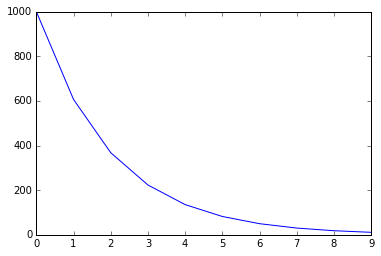

In [13]:
x = np.arange(10)
plt.plot(x, 1000*np.exp(-x/2.));

In [ ]:
# grid search

In [14]:
# tx_best, ty_best, tz_best, theta_z_best, theta_y_best = (300, -200, -90, np.deg2rad(25), 0)
# score_best_up_to_now = 777607.109912

params_best_upToNow = (0, 0, -76, np.deg2rad(0), np.deg2rad(0))
score_best_upToNow = 0

for iteration in range(1):
    
    print iteration

    init_tx, init_ty, init_tz, init_theta_z, init_theta_y = params_best_upToNow
    
    # tx_grid = np.linspace(init_tx-400,init_tx+400,10)
    # ty_grid = np.linspace(init_ty-400,init_ty+400,10)
    # tz_grid = np.linspace(init_tz-200,init_tz+200,10)
    # theta_z_grid = np.deg2rad(np.linspace(init_theta_z-20,init_theta_z+20,5))
    # theta_y_grid = np.deg2rad(np.linspace(init_theta_y-20,init_theta_y+20,5))

    n = int(1000*np.exp(-iteration/2.))

    # tx_grid = np.random.randint(init_tx-400, init_tx+400, n)
    # ty_grid = np.random.randint(init_ty-400, init_ty+400, n)
    # tz_grid = np.random.randint(init_tz-200, init_tz+200, n)
    # theta_z_grid = np.deg2rad(np.random.randint(-20, 20, n))
    # theta_y_grid = np.deg2rad(np.random.randint(-20, 20, n))

    sigma_tx = 300*np.exp(-iteration/.3)
    sigma_ty = 300*np.exp(-iteration/.3)
    sigma_tz = 200*np.exp(-iteration/.3)
    sigma_theta_z = np.deg2rad(20*np.exp(-iteration/.6))
    sigma_theta_y = np.deg2rad(20*np.exp(-iteration/.6))
   
#     tx_grid = sigma_tx * np.random.randn(n) + init_tx
#     ty_grid = sigma_ty * np.random.randn(n) + init_ty
#     tz_grid = sigma_tz * np.random.randn(n) + init_tz
#     theta_z_grid = sigma_theta_z * np.random.randn(n) + init_theta_z
#     theta_y_grid = sigma_theta_y * np.random.randn(n) + init_theta_y

    tx_grid = np.random.randint(init_tx-sigma_tx, init_tx+sigma_tx, n)
    ty_grid = np.random.randint(init_ty-sigma_ty, init_ty+sigma_ty, n)
    tz_grid = np.random.randint(init_tz-sigma_tz, init_tz+sigma_tz, n)
    theta_z_grid = 2*sigma_theta_z*np.random.random(n) - sigma_theta_z
    theta_y_grid = 2*sigma_theta_y*np.random.random(n) - sigma_theta_y

    import time
    t = time.time()

    scores = Parallel(n_jobs=16)(delayed(score_transform)(tx, ty, tz, theta_z, theta_y ) 
                 for tx, ty, tz, theta_z, theta_y in zip(tx_grid, ty_grid, tz_grid, theta_z_grid, theta_y_grid))

    print time.time() - t, 'seconds'

    score_best = np.max(scores)

    tx_best, ty_best, tz_best, theta_z_best, theta_y_best = \
    zip(tx_grid, ty_grid, tz_grid, theta_z_grid, theta_y_grid)[np.argmax(scores)]
    
    if score_best > score_best_upToNow:
        print score_best_upToNow, score_best

        score_best_upToNow = score_best
        params_best_upToNow = tx_best, ty_best, tz_best, theta_z_best, theta_y_best
        
        print tx_best, ty_best, tz_best, np.rad2deg(theta_z_best), np.rad2deg(theta_y_best)

0
123.463016033 seconds
0 452885.863111
167 -164 -42 7.41441260502 -6.73125513301


In [62]:
test_dims = volume2_allLabels[l-1].shape

In [63]:
dSdxyz = [np.gradient(volume2_allLabels[l-1], 5,5,10) for l in range(1, 10)]

In [64]:
def optimal_global_rigid_params(init_params, iter_num=100, return_scores=False):
    
    tx_best, ty_best, tz_best, theta_z_best, theta_y_best = init_params
    
    scores = []

    for iteration in range(iter_num):

        dMdu = 0
        dMdv = 0
        dMdw = 0
        dMdaz = 0
        dMday = 0

        cos_z = np.cos(theta_z_best)
        sin_z = np.sin(theta_z_best)
        cos_y = np.cos(theta_y_best)
        sin_y = np.sin(theta_y_best)
        Rz = np.array([[cos_z, -sin_z, 0], [sin_z, cos_z, 0], [0,0,1]])
        Ry = np.array([[cos_y, 0, -sin_y], [0, 1, 0], [sin_y,0,cos_y]])
        R_best = np.dot(Rz, Ry)

        for l in range(1, 10):
            xs_prime, ys_prime, zs_prime = (np.dot(R_best, atlas_nzs[l-1]) + \
                                            np.asarray([tx_best, ty_best, tz_best])[:,np.newaxis]).astype(np.int)

            valid = (xs_prime >= 0) & (ys_prime >= 0) & (zs_prime >= 0) & \
                (xs_prime < test_dims[0]) & (ys_prime < test_dims[1]) & (zs_prime < test_dims[2])

            if np.count_nonzero(valid) > 0:

                xs_prime_valid = xs_prime[valid]
                ys_prime_valid = ys_prime[valid]
                zs_prime_valid = zs_prime[valid]

                xs, ys, zs = atlas_nzs[l-1]
                xs_valid = xs[valid]
                ys_valid = ys[valid]
                zs_valid = zs[valid]

                dMdu += dSdxyz[l-1][0][xs_prime_valid, ys_prime_valid, zs_prime_valid].sum()
                dMdv += dSdxyz[l-1][1][xs_prime_valid, ys_prime_valid, zs_prime_valid].sum()
                dMdw += dSdxyz[l-1][2][xs_prime_valid, ys_prime_valid, zs_prime_valid].sum()

    #             dMdu += dSdxyz[l-1][0][xs_prime_valid, ys_prime_valid, zs_prime_valid].mean()
    #             dMdv += dSdxyz[l-1][1][xs_prime_valid, ys_prime_valid, zs_prime_valid].mean()
    #             dMdw += dSdxyz[l-1][2][xs_prime_valid, ys_prime_valid, zs_prime_valid].mean()

#                 dMdaz += \
#                 np.dot(dSdxyz[l-1][0][xs_prime_valid, ys_prime_valid, zs_prime_valid],
#                        -np.sin(theta_z_best)*np.cos(theta_y_best)*xs_valid - np.cos(theta_z_best)*ys_valid + np.sin(theta_z_best)*np.sin(theta_y_best)*zs_valid) + \
#                 np.dot(dSdxyz[l-1][1][xs_prime_valid, ys_prime_valid, zs_prime_valid],
#                        np.cos(theta_z_best)*np.cos(theta_y_best)*xs_valid - np.sin(theta_z_best)*ys_valid - np.cos(theta_z_best)*np.sin(theta_y_best)*zs_valid)

#                 dMday += \
#                 np.dot(dSdxyz[l-1][0][xs_prime_valid, ys_prime_valid, zs_prime_valid],
#                        -np.cos(theta_z_best)*np.sin(theta_y_best)*xs_valid - np.cos(theta_z_best)*np.cos(theta_y_best)*zs_valid) + \
#                 np.dot(dSdxyz[l-1][1][xs_prime_valid, ys_prime_valid, zs_prime_valid],
#                        -np.sin(theta_z_best)*np.sin(theta_y_best)*xs_valid - np.sin(theta_z_best)*np.cos(theta_y_best)*zs_valid) +\
#                 np.dot(dSdxyz[l-1][2][xs_prime_valid, ys_prime_valid, zs_prime_valid],
#                        np.cos(theta_y_best)*xs_valid - np.sin(theta_y_best)*zs_valid)

        print '(dMdu, dMdv, dMdw):', dMdu, dMdv, dMdw
        print '(dMdaz, dMday):', dMdaz, dMday

        lr1 = .01 * np.exp(-iteration/10.)
    #     lr1 = 10. * np.exp(-iteration/10.)
        lr2 = 1e-6 * np.exp(-iteration/5.)
        print 'lr1:', lr1, 'lr2:', lr2
        tx_best += lr1*dMdu
        ty_best += lr1*dMdv
        tz_best += lr1*dMdw
        theta_z_best += lr2*dMdaz
        theta_y_best += lr2*dMday

        theta_z_best = theta_z_best%(2*np.pi)
        if theta_z_best > np.pi:
            theta_z_best -= 2*np.pi
        elif theta_z_best < -np.pi:
            theta_z_best += 2*np.pi

        theta_y_best = theta_y_best%(2*np.pi)
        if theta_y_best > np.pi:
            theta_y_best -= 2*np.pi
        elif theta_y_best < -np.pi:
            theta_y_best = theta_y_best%(2*np.pi)

        print '(tx_best, ty_best, tz_best):', tx_best, ty_best, tz_best
        print '(theta_z_best, theta_y_best):', theta_z_best, theta_y_best
        print '(theta_z_best, theta_y_best) in degrees:', np.rad2deg(theta_z_best), np.rad2deg(theta_y_best)

        s = score_transform(tx_best, ty_best, tz_best, theta_z_best, theta_y_best)
        print 'score:', s
        scores.append(s)

        print '\n'
        
    best_params = (tx_best, ty_best, tz_best, theta_z_best, theta_y_best)

    if return_scores:
        return best_params, scores
    else:
        return best_params

In [32]:
best_global_params, scores = optimal_global_rigid_params(init_params=(300, -200, -90, np.deg2rad(25), 0), 
                                                         iter_num=100, 
                                                         return_scores=True)
print best_global_params

(dMdu, dMdv, dMdw): 294.286503164 276.162117574 -158.229444627
(dMdaz, dMday): 0 0
lr1: 0.01 lr2: 1e-06
(tx_best, ty_best, tz_best): 302.942865032 -197.238378824 -91.5822944463
(theta_z_best, theta_y_best): 0.436332312999 0.0
(theta_z_best, theta_y_best) in degrees: 25.0 0.0
score: 791069.970206


(dMdu, dMdv, dMdw): 3.22684806948 30.019912514 677.299795965
(dMdaz, dMday): 0 0
lr1: 0.00904837418036 lr2: 8.18730753078e-07
(tx_best, ty_best, tz_best): 302.97206276 -196.966747423 -85.4538324601
(theta_z_best, theta_y_best): 0.436332312999 0.0
(theta_z_best, theta_y_best) in degrees: 25.0 0.0
score: 733279.92414


(dMdu, dMdv, dMdw): 217.690293294 207.885267484 573.938004858
(dMdaz, dMday): 0 0
lr1: 0.00818730753078 lr2: 6.70320046036e-07
(tx_best, ty_best, tz_best): 304.754360138 -195.264726807 -80.7548255107
(theta_z_best, theta_y_best): 0.436332312999 0.0
(theta_z_best, theta_y_best) in degrees: 25.0 0.0
score: 754763.144993


(dMdu, dMdv, dMdw): 169.180658251 311.30471911 -676.16480063

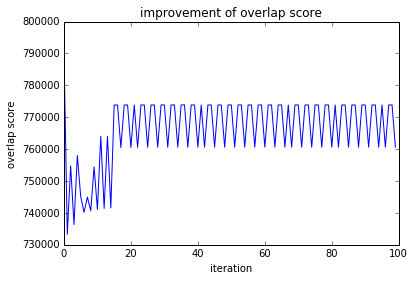

In [33]:
plt.plot(scores);
plt.title('improvement of overlap score');
plt.xlabel('iteration');
plt.ylabel('overlap score');

In [ ]:
# 244.541596321 -185.378160043 -90.9999447197 0.336902389324 0.0

In [65]:
# tx_best, ty_best, tz_best, theta_z_best, theta_y_best = params_best_upToNow
# tx_best, ty_best, tz_best, theta_z_best, theta_y_best = (300, -200, -90, np.deg2rad(25), 0)

# tx_best, ty_best, tz_best, theta_z_best, theta_y_best = (0, 0, -76, 0, 0)
# tx_best, ty_best, tz_best, theta_z_best, theta_y_best = (250, -152, -120, np.deg2rad(15), 0)
# tx_best, ty_best, tz_best, theta_z_best, theta_y_best = (250, -150, -120, np.deg2rad(15), 0)
# tx_best, ty_best, tz_best, theta_z_best, theta_y_best = (300, -200, -90, np.deg2rad(25), np.deg2rad(5))

tx_best, ty_best, tz_best, theta_z_best, theta_y_best = best_global_params
# print tx_best, ty_best, tz_best, theta_z_best, theta_y_best

cos_z = np.cos(theta_z_best)
sin_z = np.sin(theta_z_best)
cos_y = np.cos(theta_y_best)
sin_y = np.sin(theta_y_best)
Rz = np.array([[cos_z, -sin_z, 0], [sin_z, cos_z, 0], [0,0,1]])
Ry = np.array([[cos_y, 0, -sin_y], [0, 1, 0], [sin_y,0,cos_y]])
R_best = np.dot(Rz, Ry)    

In [77]:
# T_best = np.c_[R_best, [tx_best, ty_best, tz_best]]
# np.dot(T_best, np.vstack([vs, np.ones((len(vs[0]),))]))

In [80]:
atlas_nzs_projected_to_test = [ (np.dot(R_best, vs) + \
                                 np.asarray([tx_best, ty_best, tz_best])[:,np.newaxis]).astype(np.int)
#     np.dot(T_best, np.vstack([vs, np.ones((len(vs[0]),))])) 
                               for vs in atlas_nzs]

In [81]:
print np.min(atlas_nzs_projected_to_test[0], axis=1)
print np.max(atlas_nzs_projected_to_test[0], axis=1)

[191 177 -37]
[565 737 831]


In [82]:
volume2_allLabels[0].shape

(750, 1380, 54)

In [83]:
test_volume_atlas_projected = np.zeros_like(volume2_allLabels[0], np.int)
test_dims = test_volume_atlas_projected.shape

In [86]:
for l in range(1, 10):
    
    test_xs, test_ys, test_zs = atlas_nzs_projected_to_test[l-1].astype(np.int)
    
    valid = (test_xs >= 0) & (test_ys >= 0) & (test_zs >= 0) & \
        (test_xs < test_dims[0]) & (test_ys < test_dims[1]) & (test_zs < test_dims[2])
    
    atlas_xs, atlas_ys, atlas_zs = atlas_nzs[l-1]
    
    test_volume_atlas_projected[test_xs[valid], test_ys[valid], test_zs[valid]] = \
    volume1[atlas_xs[valid], atlas_ys[valid], atlas_zs[valid]]
    
test_volume_atlas_projected.shape

(750, 1380, 54)

In [19]:
colors = np.loadtxt(os.environ['REPO_DIR'] + '/visualization/100colors.txt')
colors[label_dict['BackG']] = 1.

In [20]:
cropped_imgs = {}
for s in range(157,167):
    dm = DataManager(stack='MD594', section=s, load_mask=False)
    dm._load_image(versions=['rgb-jpg'])
    cropped_imgs[s] = dm.image_rgb_jpg[::8, ::8][567:1316+1, 399:1778+1]

/oasis/projects/nsf/csd181/yuncong/virtualenv-1.9.1/yuncongve/lib/python2.7/site-packages/PIL/Image.py:2224: DecompressionBombWarning: Image size (167180288 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


In [91]:
cropped_imgs.keys()

[160, 161, 162, 163, 164, 165, 166, 157, 158, 159]

In [92]:
567 1316
399 1778
853 906

SyntaxError: invalid syntax (<ipython-input-92-485c3e3fb7a9>, line 1)

93 364


In [ ]:
for z in range(0,54,10):
#     viz1 = plt.cm.hot(volume2_allLabels[label_dict['5N']-1][...,i])
    viz1 = cropped_imgs[map_z_to_section[z]]
    viz2 = colors[test_volume_atlas_projected[...,z]]
    viz = alpha_blending(viz2, viz1[...,:3], .2, 1.)
    plt.figure(figsize=(15,15));
    plt.title('section = %d, z = %.2f'%(map_z_to_section[z], z))
    plt.imshow(viz);
    plt.show();
    
    cv2.imwrite('/oasis/projects/nsf/csd395/yuncong/CSHL_annotaionsPojectedViz/cropped_image_z%d.jpg'%z, 
                img_as_ubyte(viz[..., [2,1,0,3]]))

In [96]:
from skimage.measure import find_contours

In [ ]:
# z = 0
# viz1 = cropped_imgs[map_z_to_section[z]]
# viz2 = colors[test_volume_atlas_projected[...,z]]
# viz = img_as_ubyte(alpha_blending(viz2, viz1[...,:3], .2, 1.))

# for l, pts in contour_points.iteritems():
#     for pt in pts:
#         cv2.circle(viz, tuple(pt), 5, (int(colors[l,0]*255),int(colors[l,1]*255),int(colors[l,2]*255), 255), -1)
    
# plt.figure(figsize=(15,15));
# plt.title('section = %d, z = %.2f'%(map_z_to_section[z], z))
# plt.imshow(viz);
# plt.show();

In [ ]:
# z = 0

# viz1 = cropped_imgs[map_z_to_section[z]]
# # viz2 = colors[test_volume_atlas_projected[...,z]]
# viz3 = plt.cm.hot(volume2_allLabels[label_dict['7N']-1][...,z])[...,:3]
# # viz = img_as_ubyte(alpha_blending(viz3, alpha_blending(viz2, viz1[...,:3], .2, 1.)[...,:3], .1, 1))
# viz = img_as_ubyte(alpha_blending(viz3, viz1[...,:3], .1, 1))

# for l, pts in contour_points.iteritems():
#     for pt in pts:
#         cv2.circle(viz, tuple(pt), 2, (int(colors[l,0]*255),int(colors[l,1]*255),int(colors[l,2]*255), 255), -1)
    
# plt.figure(figsize=(15,15));
# plt.title('section = %d, z = %.2f'%(map_z_to_section[z], z))
# plt.imshow(viz);
# plt.show();

In [97]:
label_dict

{'12N': 4,
 '5N': 1,
 '7N': 3,
 '7n': 2,
 'BackG': 0,
 'Gr': 5,
 'LVe': 6,
 'Pn': 7,
 'SuVe': 8,
 'VLL': 9}

In [98]:
# local rigid transformation

In [99]:
global_rigid_best = (tx_best, ty_best, tz_best, theta_z_best, theta_y_best)

In [349]:
def optimal_params_slice(labelname, z, init_params=(0,0,0,1), iter_num=100, return_scores=False):
    
    atlas_slice_nzs = np.where(test_volume_atlas_projected[...,z] == label_dict[labelname])
    
    l = label_dict[labelname]
    
    scores = []

    tx_best, ty_best, theta_z_best, sc_best  = init_params

    for iteration in range(iter_num):

        dMdu = 0
        dMdv = 0
        dMdaz = 0
        dMds = 0

        cos_z = np.cos(theta_z_best)
        sin_z = np.sin(theta_z_best)
        Rz_best = np.array([[cos_z, -sin_z], [sin_z, cos_z]])    

        xs_prime, ys_prime = (np.dot(sc_best * Rz_best, atlas_slice_nzs) + \
                              np.asarray([tx_best, ty_best])[:,np.newaxis]).astype(np.int)

        valid = (xs_prime >= 0) & (ys_prime >= 0) & \
                (xs_prime < test_dims[0]) & (ys_prime < test_dims[1])

        if np.count_nonzero(valid) > 0:

            xs_prime_valid = xs_prime[valid]
            ys_prime_valid = ys_prime[valid]

            xs, ys = atlas_slice_nzs
            xs_valid = xs[valid]
            ys_valid = ys[valid]

            dMdu += dSdxyz[l-1][0][xs_prime_valid, ys_prime_valid, z].sum()
            dMdv += dSdxyz[l-1][1][xs_prime_valid, ys_prime_valid, z].sum()

            dMdaz += \
                np.dot(dSdxyz[l-1][0][xs_prime_valid, ys_prime_valid, z],
                       -sc_best*np.sin(theta_z_best)*xs_valid - sc_best*np.cos(theta_z_best)*ys_valid) + \
                np.dot(dSdxyz[l-1][1][xs_prime_valid, ys_prime_valid, z],
                       sc_best*np.cos(theta_z_best)*xs_valid - sc_best*np.sin(theta_z_best)*ys_valid)
                
            dMds += np.dot(dSdxyz[l-1][0][xs_prime_valid, ys_prime_valid, z],
                        np.cos(theta_z_best)*xs_valid - np.sin(theta_z_best)*ys_valid) + \
                    np.dot(dSdxyz[l-1][1][xs_prime_valid, ys_prime_valid, z],
                        np.sin(theta_z_best)*xs_valid + np.cos(theta_z_best)*ys_valid)

        print '(dMdu, dMdv):', dMdu, dMdv
        print '(dMdaz):', dMdaz
        print '(dMds):', dMds

    #     lr1 = .1 * np.exp(-iteration/100.)
        lr1 = .1
        lr2 = 1e-6 * np.exp(-iteration/10.)
#         lr2 = 1e-6
#         lr3 = 1e-6
        lr3 = 0
    
        print 'lr1:', lr1, 'lr2:', lr2
        tx_best += lr1*dMdu
        ty_best += lr1*dMdv
        theta_z_best += lr2*dMdaz
        
        theta_z_best = theta_z_best%(2*np.pi)
        if theta_z_best > np.pi:
            theta_z_best -= 2*np.pi
        elif theta_z_best < -np.pi:
            theta_z_best += 2*np.pi

        sc_best += lr3*dMds
#         sc_best = max(0.8, min(1.2, sc_best))
            
        print '(tx_best, ty_best, tz_best):', tx_best, ty_best, tz_best
        print '(sc_best):', sc_best
        print '(theta_z_best):', theta_z_best
        print '(theta_z_best) in degrees:', np.rad2deg(theta_z_best)

        s = volume2_allLabels[l-1][xs_prime_valid, ys_prime_valid, z].sum()

        print 'score:', s
        scores.append(s)

        print '\n'
        
    best_finetune_params = (tx_best, ty_best, theta_z_best, sc_best)
    
    if return_scores:
        return best_finetune_params, scores
    else:
        return best_finetune_params

In [350]:
def find_contour_points(labelmap):
    '''
    return is (x,y)
    '''

    regions = regionprops(labelmap)

    contour_points = {}

    for r in regions:

        (min_row, min_col, max_row, max_col) = r.bbox

        padded = np.pad(r.filled_image, ((5,5),(5,5)), mode='constant', constant_values=0)

        contours = find_contours(padded, .5, fully_connected='high')
        contours = [cnt.astype(np.int) for cnt in contours if len(cnt) > 10]
        assert len(contours) == 1

        pts = contours[0] - (5,5)

        pts_sampled = pts[np.arange(0, pts.shape[0], 10)]

#         viz = np.zeros_like(r.filled_image)
#         viz[pts_sampled[:,0], pts_sampled[:,1]] = 1
#         plt.imshow(viz, cmap=plt.cm.gray);
#         plt.show();

        contour_points[r.label] = pts_sampled[:, ::-1] + (min_col, min_row)
        
    return contour_points

In [594]:
# label = 'VLL'
z_level = 40

scores_allLandmarks = {}

labelmap = test_volume_atlas_projected[..., z_level]
atlas_projected_contour_points = find_contour_points(labelmap)

finetune_params_allLandmarks = {}
for label_id in set(np.unique(labelmap)) - {0}:
    (tx_best, ty_best, theta_z_best, sc_best), scores = optimal_params_slice(labels[label_id], z_level, 
                                                                             iter_num=300, return_scores=True)
    
    scores_allLandmarks[labels[label_id]] = scores
    
    finetune_params_allLandmarks[labels[label_id]] = (tx_best, ty_best, theta_z_best, sc_best)

(dMdu, dMdv): -3.7114362124 19.8539304307
(dMdaz): 8193.38033604
(dMds): 3810.86845858
lr1: 0.1 lr2: 1e-06
(tx_best, ty_best, tz_best): -0.37114362124 1.98539304307 -80.9999763078
(sc_best): 1.0
(theta_z_best): 0.00819338033604
(theta_z_best) in degrees: 0.469446113201
score: 10872.6870962


(dMdu, dMdv): -2.47375388678 11.0578236555
(dMdaz): 4669.32588332
(dMds): 1112.82739517
lr1: 0.1 lr2: 9.04837418036e-07
(tx_best, ty_best, tz_best): -0.618519009918 3.09117540862 -80.9999763078
(sc_best): 1.0
(theta_z_best): 0.0124183611123
(theta_z_best) in degrees: 0.711519680203
score: 11266.082924


(dMdu, dMdv): -2.25626536385 6.61585110042
(dMdaz): 2971.94937044
(dMds): -301.54541269
lr1: 0.1 lr2: 8.18730753078e-07
(tx_best, ty_best, tz_best): -0.844145546304 3.75276051866 -80.9999763078
(sc_best): 1.0
(theta_z_best): 0.0148515874584
(theta_z_best) in degrees: 0.850933280438
score: 11390.9112492


(dMdu, dMdv): -2.01397873477 5.18398058315
(dMdaz): 2366.46456297
(dMds): -730.85183278
lr1: 0.1

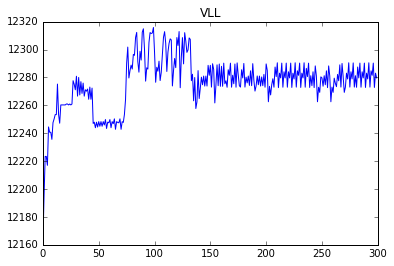

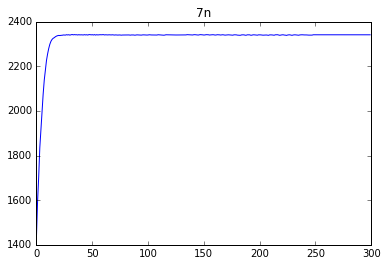

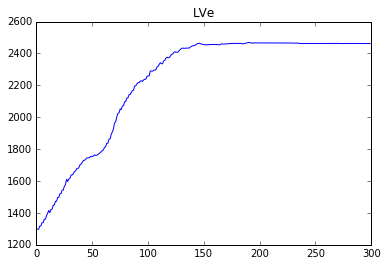

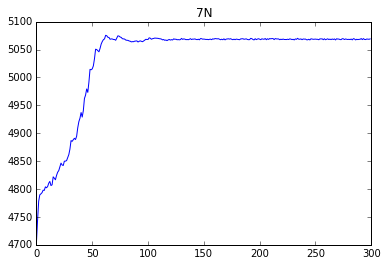

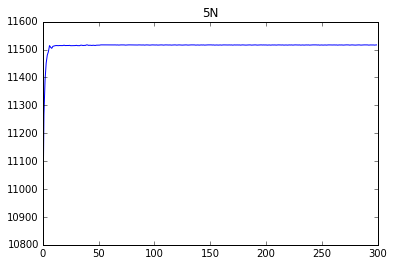

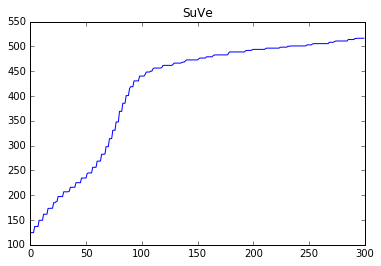

In [595]:
for l, scs in scores_allLandmarks.iteritems():
    plt.plot(scs);
    plt.title(l);
    plt.show();

In [596]:
distance_transforms.keys()

[1, 2, 3, 6, 8, 9]

5N -1.68314874579 5.72149418039 1.09638475106 1.0
7n 0.403291205789 -11.9353325934 -1.67404454652 1.0
7N 5.93960341606 -17.3109687664 -0.786852309847 1.0
LVe 9.55760292431 57.6938051574 0.313218439697 1.0
SuVe 13.3399200203 38.2588491876 0.0552907733421 1.0
VLL -6.06382622381 -1.61906299854 -0.0400623038715 1.0


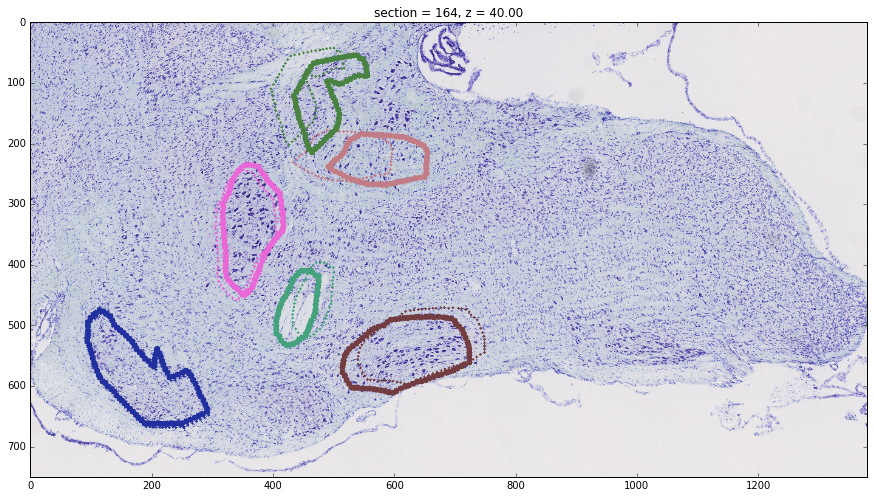

In [597]:
viz1 = cropped_imgs[map_z_to_section[z_level]]
# viz2 = colors[test_volume_atlas_projected[...,z]]
# viz3 = plt.cm.hot(volume2_allLabels[label_dict[label]-1][...,z])[...,:3]
# viz = img_as_ubyte(alpha_blending(viz3, alpha_blending(viz2, viz1[...,:3], .2, 1.)[...,:3], .1, 1))
# viz = img_as_ubyte(alpha_blending(viz3, viz1[...,:3], .1, 1))
viz = viz1.copy()

for l in set(np.unique(labelmap)) - {0}:
    for pt in atlas_projected_contour_points[l]:
        cv2.circle(viz, tuple(pt), 2, (int(colors[l,0]*255),int(colors[l,1]*255),int(colors[l,2]*255), 255), -1)
    
    tx_best, ty_best, theta_z_best, sc_best = finetune_params_allLandmarks[labels[l]]
    print labels[l], tx_best, ty_best, np.rad2deg(theta_z_best), sc_best

    cos_z = np.cos(theta_z_best)
    sin_z = np.sin(theta_z_best)
    Rz_best = np.array([[cos_z, -sin_z], [sin_z, cos_z]])    
    xs, ys = (np.dot(sc_best * Rz_best, atlas_projected_contour_points[l][:, ::-1].T) + \
              np.asarray([tx_best, ty_best])[:,np.newaxis]).astype(np.int)
    valid = (xs >= 0) & (ys >= 0) & (xs < test_dims[0]) & (ys < test_dims[1])

    for pt in np.c_[xs, ys][valid][:, ::-1]:
        cv2.circle(viz, tuple(pt), 5, (int(colors[l,0]*255),int(colors[l,1]*255),int(colors[l,2]*255), 255), -1)
        
plt.figure(figsize=(15,15));
plt.title('section = %d, z = %.2f'%(map_z_to_section[z_level], z_level))
plt.imshow(viz);
plt.show();

In [598]:
from scipy.ndimage.morphology import distance_transform_edt
from skimage.morphology import remove_small_holes

In [599]:
filled_labelmap = np.zeros_like(labelmap, np.int)

In [600]:
distance_transforms = {}
for l in set(np.unique(labelmap)) - {0}:
    m = remove_small_holes(labelmap == l) 
    
    filled_labelmap[m] = l
    
    D = distance_transform_edt(~m, return_indices=False, return_distances=True)
    distance_transforms[l] = D

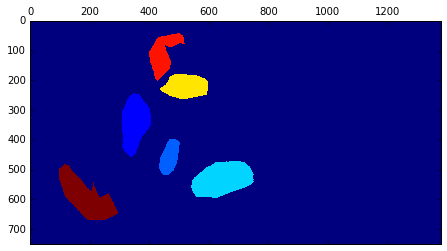

In [601]:
plt.matshow(filled_labelmap)

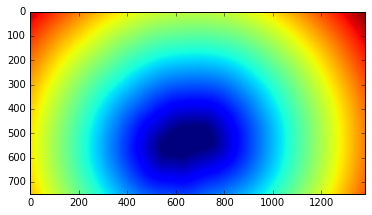

In [602]:
plt.imshow(distance_transforms[3]);

In [615]:
dt_arr = np.dstack(distance_transforms.values())

mu = 3
object_weights = dt_arr**(-mu) / np.sum(dt_arr**(-mu), axis=-1)[..., np.newaxis]

/oasis/projects/nsf/csd181/yuncong/virtualenv-1.9.1/yuncongve/lib/python2.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: divide by zero encountered in power
/oasis/projects/nsf/csd181/yuncong/virtualenv-1.9.1/yuncongve/lib/python2.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in divide


In [616]:
finetune_params_allLandmarks_arr = \
np.asarray([finetune_params_allLandmarks[labels[l]] for l in distance_transforms.keys()])

In [617]:
interpolation_map = np.dot(object_weights.reshape((-1, object_weights.shape[-1])), 
       finetune_params_allLandmarks_arr).reshape((object_weights.shape[0], object_weights.shape[1], 
                                                  finetune_params_allLandmarks_arr.shape[-1]))

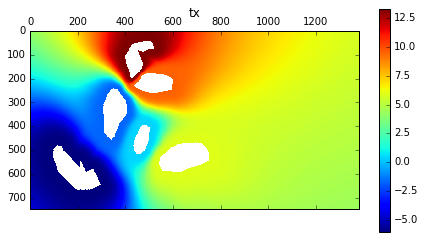

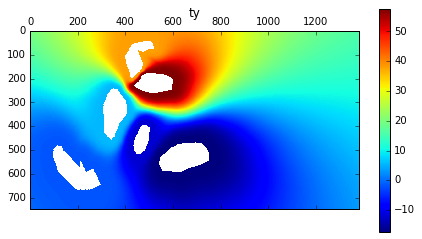

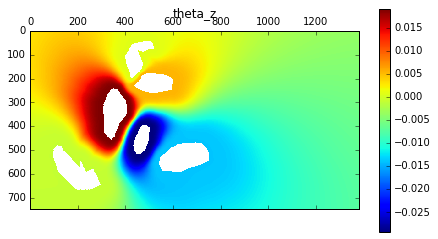

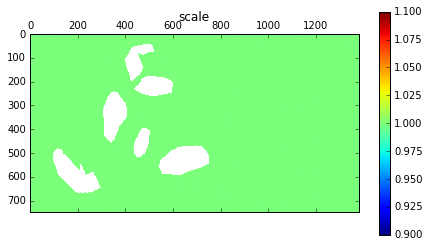

In [618]:
plt.matshow(interpolation_map[..., 0])
plt.title('tx');
plt.colorbar();
plt.show()

plt.matshow(interpolation_map[..., 1])
plt.title('ty');
plt.colorbar();
plt.show()

plt.matshow(interpolation_map[..., 2])
plt.title('theta_z');
plt.colorbar();
plt.show()

plt.matshow(interpolation_map[..., 3])
plt.title('scale');
plt.colorbar();
plt.show()

In [619]:
grid_viz = np.zeros((test_dims[0], test_dims[1], 3), np.uint8)
grid_viz[::20, :] = 255
grid_viz[:, ::20] = 255

for l in set(np.unique(labelmap)) - {0}:
    for pt in atlas_projected_contour_points[l]:
        cv2.circle(grid_viz, tuple(pt), 2, (int(colors[l,0]*255),int(colors[l,1]*255),int(colors[l,2]*255), 255), -1)
        
        
#     tx_best, ty_best, theta_z_best, sc_best = finetune_params_allLandmarks[labels[l]]
#     print labels[l], tx_best, ty_best, np.rad2deg(theta_z_best), sc_best

#     cos_z = np.cos(theta_z_best)
#     sin_z = np.sin(theta_z_best)
#     Rz_best = np.array([[cos_z, -sin_z], [sin_z, cos_z]])    
#     xs, ys = (np.dot(sc_best * Rz_best, atlas_projected_contour_points[l][:, ::-1].T) + \
#               np.asarray([tx_best, ty_best])[:,np.newaxis]).astype(np.int)
#     valid = (xs >= 0) & (ys >= 0) & (xs < test_dims[0]) & (ys < test_dims[1])

#     for pt in np.c_[xs, ys][valid][:, ::-1]:
#         cv2.circle(grid_viz, tuple(pt), 5, (int(colors[l,0]*255),int(colors[l,1]*255),int(colors[l,2]*255), 255), -1)
        

In [620]:
viz1 = cropped_imgs[map_z_to_section[z_level]]
viz = alpha_blending(grid_viz, viz1, .5, 1)

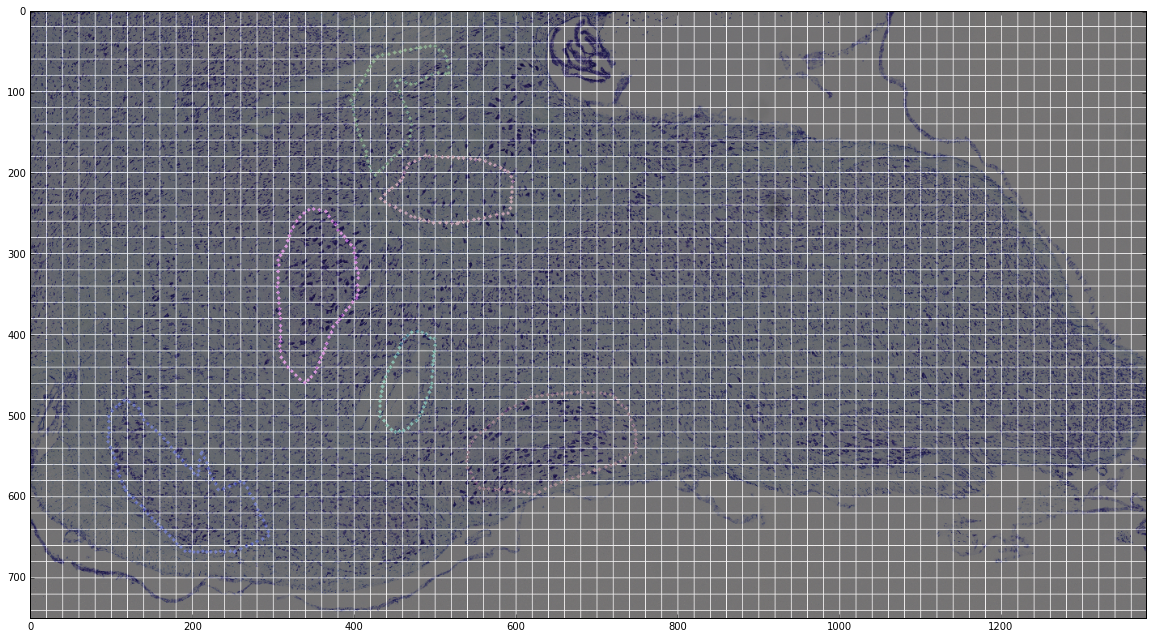

In [621]:
plt.figure(figsize=(20,20))
# plt.imshow(grid_viz, cmap=plt.cm.gray)
plt.imshow(viz, cmap=plt.cm.gray)

In [622]:
# xs, ys = np.meshgrid(range(test_dims[0]), range(test_dims[1]))
ys, xs = np.where(grid_viz[...,0])

In [623]:
warped_grid_viz = np.zeros_like(grid_viz)

In [624]:
for x, y in np.c_[xs, ys]:
    
    if filled_labelmap[y, x] == 0: # outside any object    
        tx, ty, theta_z, sc = interpolation_map[y,x]
#         continue
        
    else: # inside an object
        
        l = distance_transforms.keys().index(filled_labelmap[y, x])
#         print l, finetune_params_allLandmarks_arr[l]
        
        tx, ty, theta_z, sc = finetune_params_allLandmarks_arr[l]
        
    cos_z = np.cos(theta_z)
    sin_z = np.sin(theta_z)
    Rz = np.array([[cos_z, -sin_z], [sin_z, cos_z]])

    new_y, new_x = (np.dot(sc * Rz, [y, x]) + np.asarray([tx, ty])).astype(np.int)
    
    if new_x >= 0 and new_x < warped_grid_viz.shape[1] and new_y >= 0 and new_y < warped_grid_viz.shape[0]:
        warped_grid_viz[new_y, new_x] = grid_viz[y, x]

In [625]:
viz1 = cropped_imgs[map_z_to_section[z_level]]
viz = alpha_blending(warped_grid_viz, viz1, .5, 1)

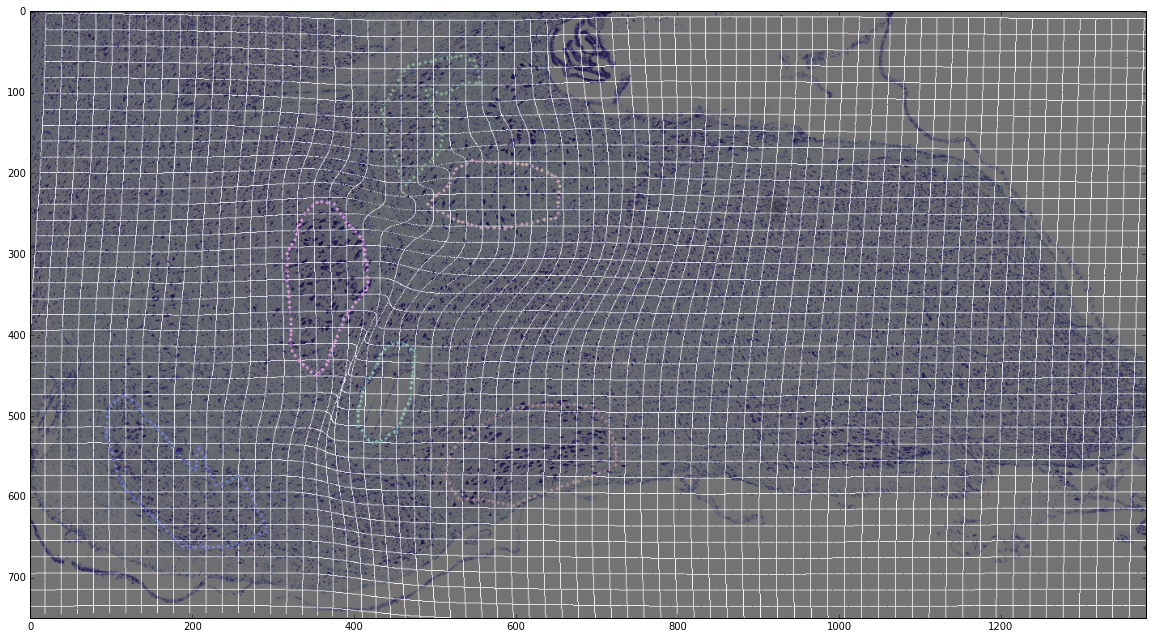

In [626]:
plt.figure(figsize=(20,20))
# plt.imshow(warped_grid_viz, cmap=plt.cm.gray)
plt.imshow(viz, cmap=plt.cm.gray)

In [ ]:
label = '7n'

contours = find_contours(volume2_allLabels[label_dict[label]-1][...,z], .5)

hot_contours = [cnt.astype(np.int)[:, ::-1] for cnt in contours if len(cnt) > 200]
print len(hot_contours)
# hot_contour = hot_contours[0]

z = 50
viz1 = cropped_imgs[map_z_to_section[z]]
# viz2 = colors[test_volume_atlas_projected[...,z]]
viz3 = plt.cm.hot(volume2_allLabels[label_dict[label]-1][...,z])[...,:3]
# viz = img_as_ubyte(alpha_blending(viz3, alpha_blending(viz2, viz1[...,:3], .2, 1.)[...,:3], .1, 1))
viz = img_as_ubyte(alpha_blending(viz3, viz1[..., :3], .1, 1))


l = label_dict[label]
for cnt in hot_contours:
    for pt in cnt:
        cv2.circle(viz, tuple(pt), 2, (int(colors[l,0]*255),int(colors[l,1]*255),int(colors[l,2]*255), 255), -1)
        
for l, pts in contour_points.iteritems():
    for pt in pts:
        cv2.circle(viz, tuple(pt), 2, (int(colors[l,0]*255),int(colors[l,1]*255),int(colors[l,2]*255), 255), -1)
    
plt.figure(figsize=(15,15));
plt.title('section = %d, z = %.2f'%(map_z_to_section[z], z))
plt.imshow(viz);
plt.show();

In [ ]:
label = '7n'

contours = find_contours(volume2_allLabels[label_dict[label]-1][...,z], .5)

hot_contours = [cnt.astype(np.int)[:, ::-1] for cnt in contours if len(cnt) > 200]
print len(hot_contours)
# hot_contour = hot_contours[0]

z = 50
viz1 = cropped_imgs[map_z_to_section[z]]
# viz2 = colors[test_volume_atlas_projected[...,z]]
viz3 = plt.cm.hot(volume2_allLabels[label_dict[label]-1][...,z])[...,:3]
# viz = img_as_ubyte(alpha_blending(viz3, alpha_blending(viz2, viz1[...,:3], .2, 1.)[...,:3], .1, 1))
viz = img_as_ubyte(alpha_blending(viz3, viz1[...,:3], .1, 1))


l = label_dict[label]-1
for cnt in hot_contours:
    for pt in cnt:
        cv2.circle(viz, tuple(pt), 2, (int(colors[l,0]*255),int(colors[l,1]*255),int(colors[l,2]*255), 255), -1)
    
for l, pts in contour_points.iteritems():
    for pt in pts:
        cv2.circle(viz, tuple(pt), 2, (int(colors[l,0]*255),int(colors[l,1]*255),int(colors[l,2]*255), 255), -1)
    
plt.figure(figsize=(15,15));
plt.title('section = %d, z = %.2f'%(map_z_to_section[z], z))
plt.imshow(viz);
plt.show();

In [ ]:
from skimage.segmentation import active_contour

In [ ]:
plt.imshow(g);
plt.colorbar();

In [ ]:
plt.imshow(u);
plt.colorbar();

In [ ]:
img = viz3[...,1]

dI_dy, dI_dx = np.gradient(gaussian_filter(img, 2))
beta = 1.
g = 1./(1. + beta*(dI_dy**2 + dI_dx**2))

f = img.copy()

dt = 1./8
theta = 1.
lamb = .01
# lamb = .0001
mu = .5

u = np.zeros_like(img, np.float)
v = np.zeros_like(img, np.float)

for k in range(100):
    print k

    px = np.zeros_like(u)
    py = np.zeros_like(u)

    for i in range(10):
        _, dpx_dx = np.gradient(px)
        dpy_dy, _ = np.gradient(py)

        div_p = dpy_dy + dpx_dx

        a = div_p - v/theta
        dady, dadx = np.gradient(a)
        norm_da = np.sqrt(dady**2+dadx**2)
        denom = 1+dt/g*(norm_da+1e-6)
        py = (py + dt*dady)/denom
        px = (px + dt*dadx)/denom

    u = v - theta*div_p
    
    if k%5 == 0:
        c1 = f[u>mu].mean()
        if np.isnan(c1):
            print 'c1 is nan'
#             c1 = 255.
            c1 = 1.
        c2 = f[u<=mu].mean()
        r1 = (c1-f)**2-(c2-f)**2
            
    plt.matshow(u, cmap=plt.cm.gray)    
#     plt.matshow(u>mu, cmap=plt.cm.gray)
    plt.colorbar()
    plt.show()
    
    v = np.minimum(1, np.maximum(0, u-theta*lamb*r1))
    
    if k > 1:
        change = np.max(np.r_[np.abs(u-u_prev), np.abs(v-v_prev)])
        print change
#         if change < 1e-5:
#             break
    
    u_prev = u
    v_prev = v
    
#     plt.matshow(v)
# #     plt.matshow(r1)
#     plt.colorbar()
#     plt.show()

In [ ]:
label = '7N'

contours = find_contours(volume2_allLabels[label_dict[label]-1][...,z], .5)
hot_contours = [cnt.astype(np.int)[:, ::-1] for cnt in contours if len(cnt) > 200]
print len(hot_contours)

z = 50
viz1 = cropped_imgs[map_z_to_section[z]]
# viz2 = colors[test_volume_atlas_projected[...,z]]
viz3 = plt.cm.hot(volume2_allLabels[label_dict[label]-1][...,z])[...,:3]
# viz = img_as_ubyte(alpha_blending(viz3, alpha_blending(viz2, viz1[...,:3], .2, 1.)[...,:3], .1, 1))
viz = img_as_ubyte(alpha_blending(viz3, viz1[...,:3], .1, 1))


snake = active_contour(viz3[...,1]/viz3[...,1].max(), 
                       contour_points[label_dict[label]].astype(np.float), 
                       max_iterations=10)


l = label_dict[label]-1
for cnt in hot_contours:
    for pt in cnt:
        cv2.circle(viz, tuple(pt), 2, (int(colors[l,0]*255),int(colors[l,1]*255),int(colors[l,2]*255), 255), -1)
    
for pt in snake.astype(np.int):
    cv2.circle(viz, tuple(pt), 2, (255,255,255, 255), -1)
    
plt.figure(figsize=(15,15));
plt.title('section = %d, z = %.2f'%(map_z_to_section[z], z))
plt.imshow(viz);
plt.show();

In [ ]:
figure, axes = plt.subplots(2,1, sharex=True, sharey=True, figsize=(20,20))
axes[0].matshow(volume2_allLabels[label_dict['5N']-1][...,50], cmap=plt.cm.hot);
axes[1].matshow(test_volume_atlas_projected[...,50]);

In [ ]:
# from itertools import product

# import time
# t = time.time()

# scores_mat = Parallel(n_jobs=16)(delayed(score_transform)(tx, ty, tz, theta_z, theta_y ) 
#              for tx, ty, tz, theta_z, theta_y in product(tx_grid, ty_grid, tz_grid, theta_z_grid, theta_y_grid))

# xi, yi, zi = np.unravel_index(np.argmax(scores_mat), scores_mat.shape)
# print tx_grid[xi], ty_grid[yi], tz_grid[zi]

# print time.time() - t

In [ ]:
canvas1.shape

In [ ]:
volume2_allLabels[0].shape

In [ ]:
cos_z = np.cos(theta_z_best)
sin_z = np.sin(theta_z_best)
cos_y = np.cos(theta_y_best)
sin_y = np.sin(theta_y_best)
Rz = np.array([[cos_z, -sin_z, 0], [sin_z, cos_z, 0], [0,0,1]])
Ry = np.array([[cos_y, 0, -sin_y], [0, 1, 0], [sin_y,0,cos_y]])
R_best = np.dot(Rz, Ry)

scores = np.empty((9,))
for l in range(1,10):
#     print l
    
    test_xs, test_ys, test_zs = (np.dot(R_best, atlas_nzs[l-1]) + \
                                 np.asarray([tx_best, ty_best, tz_best])[:,np.newaxis]).astype(np.int)
#     print test_xs.min(), test_xs.max(), test_ys.min(), test_ys.max(), test_zs.min(), test_zs.max()

    test_dims = volume2_allLabels[l-1].shape
    
    valid = (test_xs >= 0) & (test_ys >= 0) & (test_zs >= 0) & \
            (test_xs < test_dims[0]) & (test_ys < test_dims[1]) & (test_zs < test_dims[2])

    voxel_probs_valid = volume2_allLabels[l-1][test_xs[valid], test_ys[valid], test_zs[valid]]
    scores[l-1] = voxel_probs_valid.sum()
    
#     print labels[l], np.count_nonzero(voxel_probs_valid), scores[l-1]
    
score = np.sum(scores)
print score    
# print scores
# print np.sum(scores)

In [ ]:
def f(tx, ty, tz, theta_z, theta_y):
    
    cos_z = np.cos(theta_z)
    sin_z = np.sin(theta_z)
    cos_y = np.cos(theta_y)
    sin_y = np.sin(theta_y)
    Rz = np.array([[cos_z, -sin_z, 0], [sin_z, cos_z, 0], [0,0,1]])
    Ry = np.array([[cos_y, 0, -sin_y], [0, 1, 0], [sin_y,0,cos_y]])
    R = np.dot(Rz, Ry)    
    
    T = np.c_[R, [tx,ty,tz]]
#     T = np.c_[R, np.dot(R, [tx,ty,tz])]

    x1s, y1s, z1s = np.dot(T, P).astype(np.int)
    
    try:
        s = np.count_nonzero(C == canvas1[x1s, y1s, z1s])
    except IndexError:
        return 0
        
    return s